In [1]:
%matplotlib inline
%load_ext cython
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from plotting_utils import label_sample, figure_path, cpm_total
import pandas as pd
import glob
import re
import os
from multiprocessing import Pool
import seaborn as sns
from matplotlib import rcParams
from sequencing_tools.viz_tools import color_encoder, okabeito_palette, simpsons_palette
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sequencing_tools.stats_tools import normalize_count
from Bio import SeqUtils

plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize = 20)
plt.rc('ytick', labelsize = 20)
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
cpm_base = cpm_total()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:124: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  nthreads=int_use_threads)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [28]:
%%cython
from collections import Counter, defaultdict
from operator import itemgetter
import re
from xopen import xopen

sc_re = re.compile('([0-9]+)S')
cdef soft_clip_base(cigar):
    s = sc_re.findall(cigar)
    s = map(int, s)
    return sum(s)


cpdef get_start(sample_folder):
    cdef:
        str line
        str chrom, start, end, strand, cigar
        list fields
        int sstart, send
    
    tRNA_regex = re.compile('^TR[A-Z]-|^MT')
    end_loc_counter = defaultdict(Counter)
    bed_file = sample_folder + '/count_temp/small_RNA.bed.gz'
    with xopen(bed_file) as bed:
        for line in bed:
            fields = line.strip().split('\t')
            chrom, start, end, strand, cigar = itemgetter(0,1,2,5, 6)(fields)
            sstart, send = int(start), int(end)
            
            is_tRNA = tRNA_regex.search(chrom)
            is_sense = strand == "+"
            good_alignment = soft_clip_base(cigar) < 10 
            not_fulllength = (send - sstart) < 50
            if is_tRNA and is_sense and good_alignment and not_fulllength:
                end_loc_counter[long(start)][long(end)] += 1
    return end_loc_counter

prep = ['RNA (DNase I)', "RNA (DNase I - 3'P)"]#,'HEK293']#, 'MNase RNP','MNase EV']#,"HEK293"]
tsRNA = ['Full-length', "5' tRNA half","3' tRNA half", "5' tRF", "3' tRF"]
def label_tRF(x):
    if 'Full' in x:
        return tsRNA[0]
    elif 'half' in x and '5' in x:
        return tsRNA[1]
    elif 'half' in x and '3' in x:
        return tsRNA[2]
    elif 'tRF' in x and '5' in x:
        return tsRNA[3]
    elif 'tRF' in x and '3' in x:
        return tsRNA[4]

In [29]:
def read_PNAS():
    link = 'https://www.pnas.org/highwire/filestream/858778/field_highwire_adjunct_files/2/pnas.1821120116.sd02.xlsx'
    return pd.read_excel(link, sheet_name='Isoacceptors') \
        .filter(['Isoacceptor set','log2NormGroupMeans.HEK293T']) \
        .rename(columns={'log2NormGroupMeans.HEK293T':'PNAS_HEK293T',
                    'Isoacceptor set':'anticodon'})

In [30]:
sample_folders = glob.glob('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/*001')
sample_folders = filter(lambda x: re.search('^MP|^PP|^[Qq][cC][fF][0-9]+|[qQ][cC][fF]_[pP]hos|[DE][ED]|Exo|[fF]rag|GC', os.path.basename(x)), 
                     sample_folders) 
sample_folders = list(sample_folders)

In [31]:
df = pd.read_feather('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/tsRNA.feather') \
    .assign(prep = lambda d: d.samplename.map(lambda x: label_sample(x, new_label=True)))\
    .assign(is_mt = lambda d: np.where(d.tRNA.str.startswith('MT'),'MT-',''))\
    .groupby(['anticodon','prep','samplename','frag_type','aa','is_mt'], as_index=False) \
    .agg({'frag_count':'sum'}) \
    .assign(frag_fraction = lambda d: 100*d.groupby(['samplename','prep','aa','anticodon','is_mt']).frag_count.transform(lambda x: x/x.sum()))\
    .assign(cpm = lambda d: d.groupby(['samplename','prep']).frag_count.transform(lambda x: 1e6*x/x.sum()))\
    .query('frag_type != "Others"')  \
    .assign(anticodon = lambda d: d.is_mt + d.aa +'-'+ d.anticodon) \
    .sort_values(['is_mt','aa']) \
    .assign(frag_type = lambda d: d.frag_type.str.replace('half','tRNA-half'))\
    .assign(frag_type = lambda d: d.frag_type.map(label_tRF))
df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:124: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  nthreads=int_use_threads)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,anticodon,prep,samplename,frag_type,aa,is_mt,frag_count,frag_fraction,cpm
903,Ala-AGC,Crude,MPCEV_R1_001,3' tRNA half,Ala,,518896,81.020406,23185.864173
904,Ala-AGC,Crude,MPCEV_R1_001,5' tRNA half,Ala,,30,0.004684,1.340492
905,Ala-AGC,Crude,MPCEV_R1_001,Full-length,Ala,,82423,12.869525,3682.912342
907,Ala-AGC,Crude,MPCEV_R1_001,3' tRF,Ala,,2181,0.340541,97.453767
908,Ala-AGC,Crude (MNase),PPCEV_R1_001,3' tRNA half,Ala,,87218,78.166338,17924.326862


In [39]:
def plot_fragments(df, y = 'frag_fraction', 
                   figurename='', 
                   plot_mt = 'no', 
                   prep = prep, 
                   dodge = True,
                  cpm_norm = 'total'):
    plt.rc('axes', labelsize=20)
    plt.rc('xtick', labelsize = 18)
    plt.rc('ytick', labelsize = 18)
    ylab = '% Reads' if y == 'frag_fraction' else 'CPM'
    mt = df.anticodon.str.contains('MT')
    if plot_mt == 'no':
        df = df[~mt]
    elif plot_mt == 'only':
        df = df[mt]
    elif plot_mt == 'yes':
        pass
    
    if cpm_norm != 'total':        
        df = df \
            .assign(cpm = lambda d: d\
                                .groupby(['samplename','prep','frag_type'])\
                                .cpm.transform(lambda x: 1e6*x/x.sum()))

    
    anticodon = df.anticodon.unique().tolist()
    p = sns.FacetGrid(data = df.pipe(lambda d: d[d.prep.isin(prep)]), 
                col = 'frag_type', 
                col_wrap=1, 
                col_order = tsRNA,
                aspect=8,
                height=2,
                sharey=False)
    p.map(sns.stripplot,
          'anticodon',
          y,
          'prep',
          alpha=0.6,
          jitter = 0,
          hue_order = prep,
          order = anticodon,
          dodge=dodge,
          palette = ['#28378c','#ff3511','#85a9e2','#f7cd62','red'])
    for ax in p.fig.axes:
        ax.set_xticklabels(ax.get_xticklabels(),
                      rotation=70,
                      ha = 'right',
                      rotation_mode='anchor')
        for xt in ax.get_xticklabels():
            if xt.get_text().startswith('MT'):
                xt.set_color('purple')
        ax.text(0, ax.get_ylim()[1],ax.get_title().split('=')[1], size=20)
    p.set_titles('')
    p.add_legend(fontsize=20, bbox_to_anchor=(0.7,0.8))
    p.set_axis_labels('Anticodon', ylab)
    for ax in p.fig.axes:
        ax.get_yaxis().set_label_coords(-0.06,0.5)
    p.savefig(figurename, bbox_inches='tight', transparent=True)
    return p

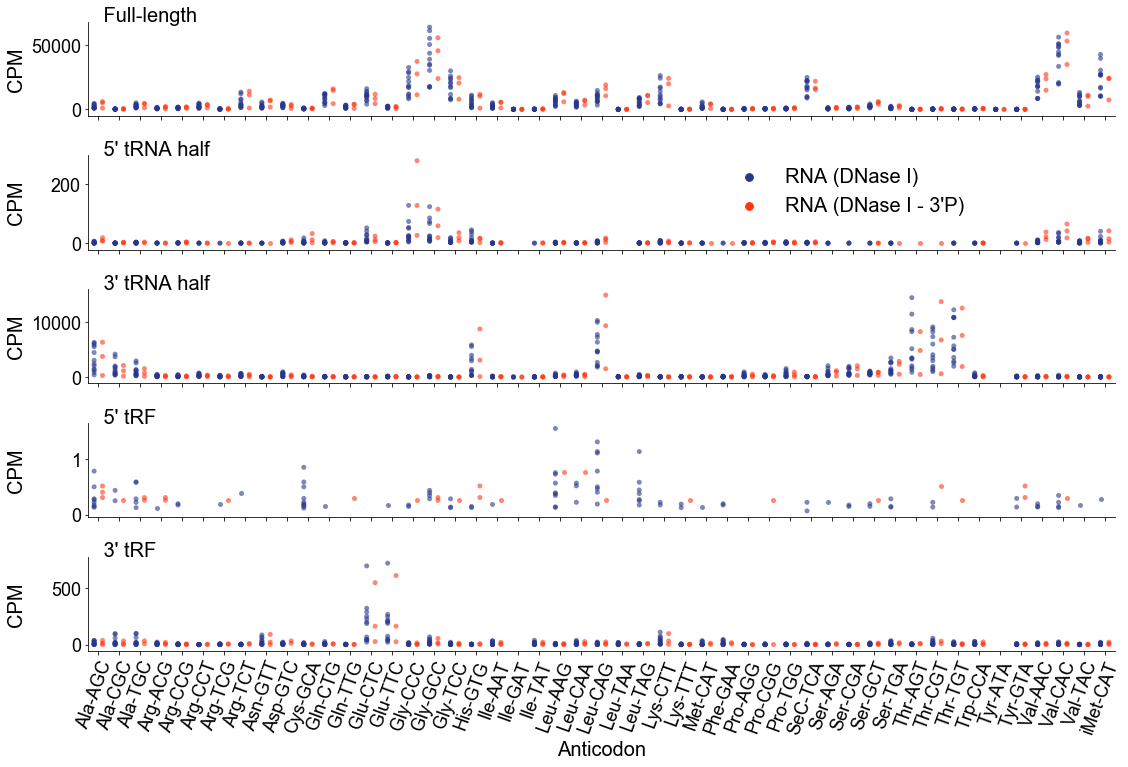

In [40]:
figurename = figure_path + '/tRNA_fragment_cpm.pdf'
p = plot_fragments(df , y = 'cpm', plot_mt = 'no', figurename = figurename)

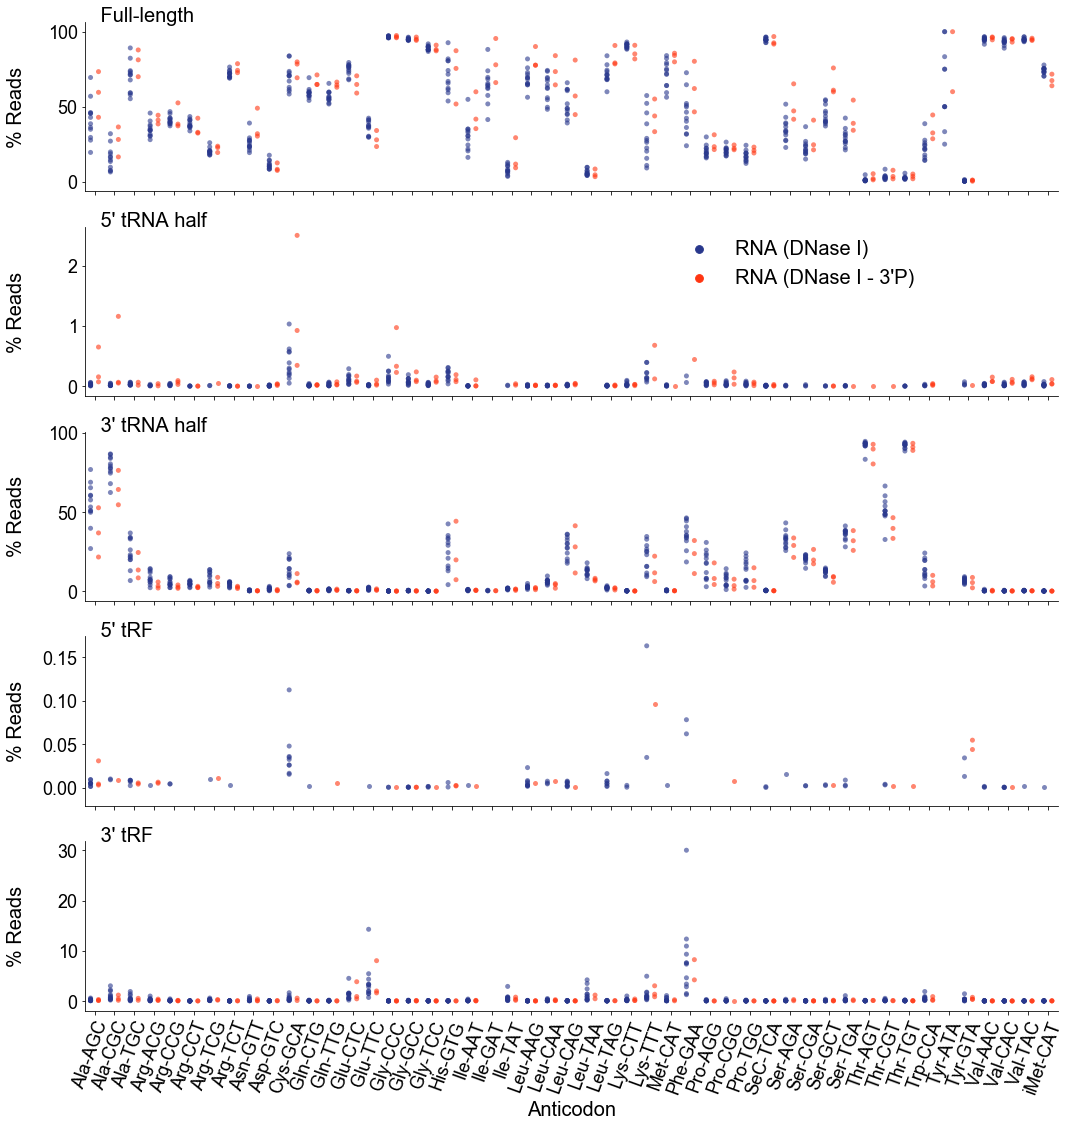

In [34]:
figurename = figure_path + '/tRNA_fragment_percentage.pdf'
plot_fragments(df , y = 'frag_fraction', figurename = figurename, plot_mt='no')

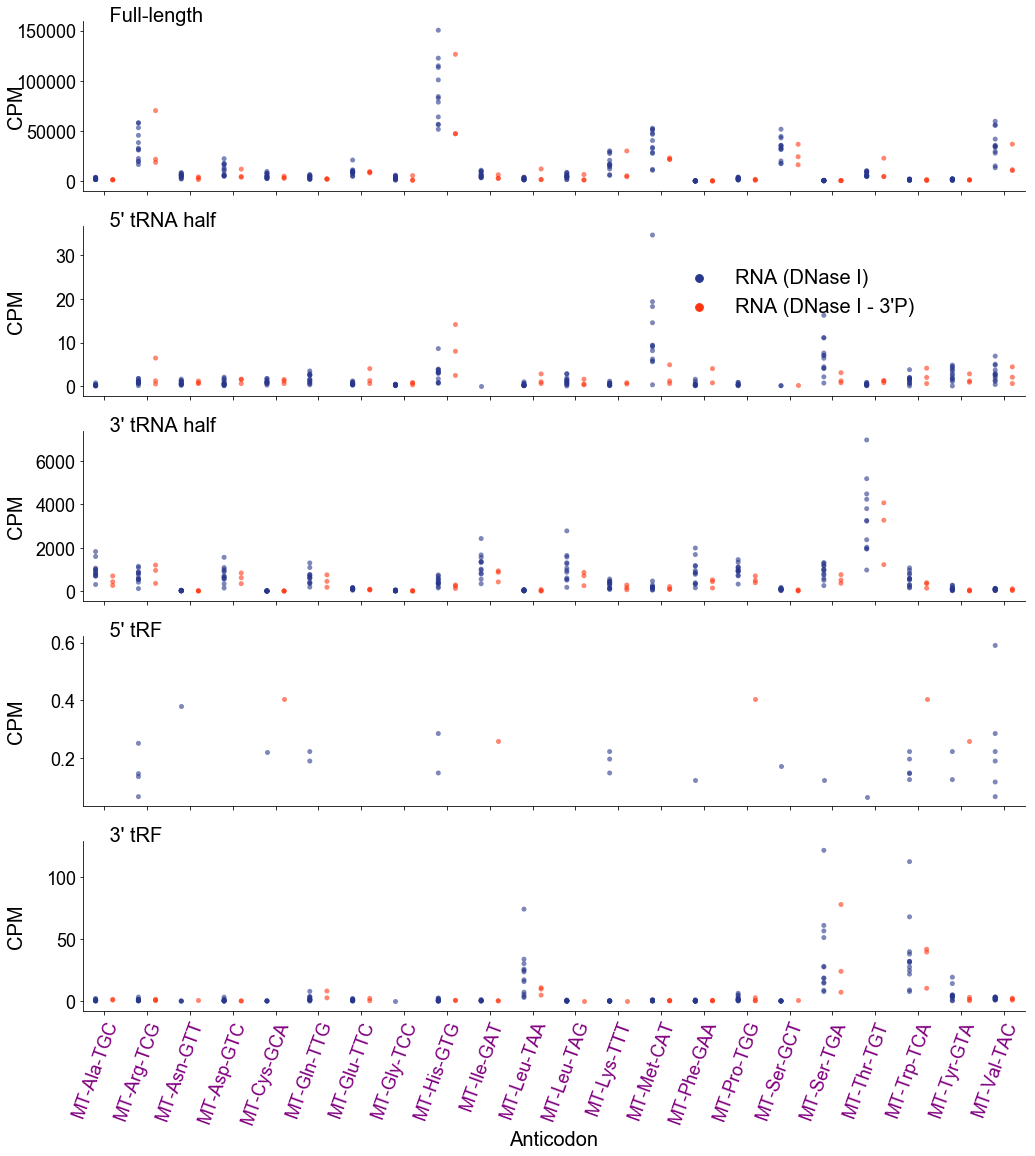

In [35]:
figurename = figure_path + '/tRNA_mt_fragment_cpm.pdf'
p = plot_fragments(df , y = 'cpm', plot_mt = 'only', figurename = figurename)

In [27]:
p = sns.FacetGrid(data = df \
        .query('prep == "DNase I"') \
        .pipe(lambda d: d[~d.anticodon.str.contains('MT')]),
    col = 'aa',
    aspect = 1,
    col_wrap = 5,
    sharex=False)
p.map(sns.stripplot,
    'anticodon',
    'frag_fraction',        
    'frag_type',
     hue_order = tsRNA,
     palette = okabeito_palette())
for ax in p.fig.axes:
    xts = ax.set_xticklabels(ax.get_xticklabels(),
                      rotation=70,
                      ha = 'right',
                      rotation_mode='anchor')
p.add_legend(frameon=False,fontsize=15, bbox_to_anchor = (0.6,0.1))
p.set_axis_labels('','% Fragments')
p.set_titles('{col_name}')
figurename = figure_path + '/fragment_percentage.pdf'
p.fig.tight_layout()
p.savefig(figurename, bbox_inches='tight')

ValueError: num must be 1 <= num <= 0, not 1

<Figure size 1080x0 with 0 Axes>

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


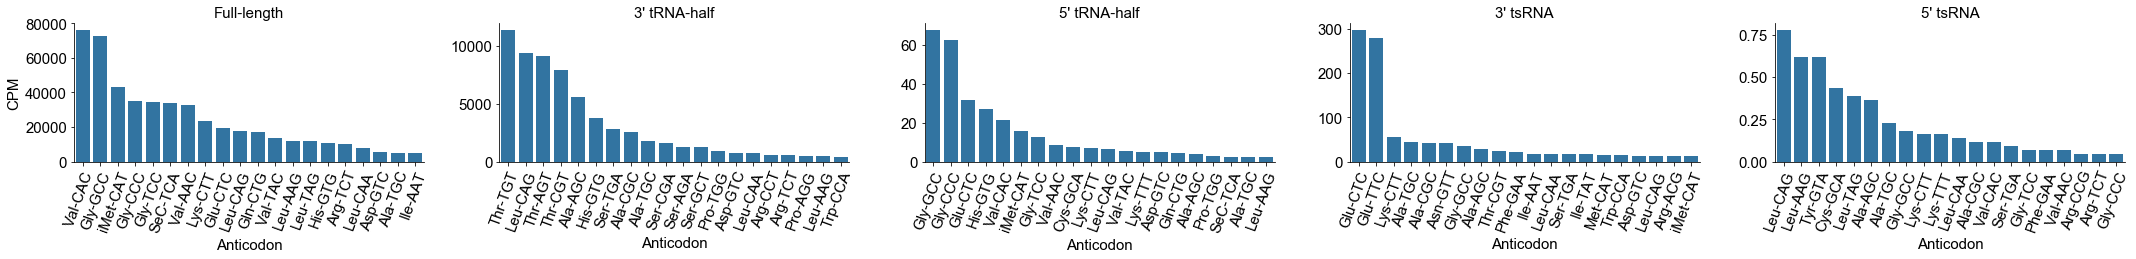

In [243]:
p = sns.FacetGrid(data = df\
        .query('prep == "DNase I"')\
        .pipe(lambda d: d[~d.anticodon.str.contains('MT')])\
        .groupby(['anticodon','frag_type'], as_index=False)\
        .agg({'frag_count':'sum'}) \
        .assign(cpm = lambda d: d.frag_count.transform(lambda x: 1e6 * x/cpm_base.prep_cpm['DNase I'])) \
        .query('cpm >0') \
        .groupby('frag_type', as_index=False)\
        .apply(lambda d: d.nlargest(20, 'cpm')),
    col = 'frag_type',
    sharex=False,
    sharey=False,
    col_order = tsRNA,
    aspect=2,
    size=3)
p.map(sns.barplot,
    'anticodon',
    'cpm')
p.set_titles('{col_name}')
for ax in p.fig.axes:
    ax.set_xticklabels(ax.get_xticklabels(), 
                       rotation=70,
                       rotation_mode='anchor',
                      ha='right')
p.set_axis_labels('Anticodon','CPM')
p.savefig(figure_path + '/tsRNA_bar.pdf', bbox_inches='tight')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


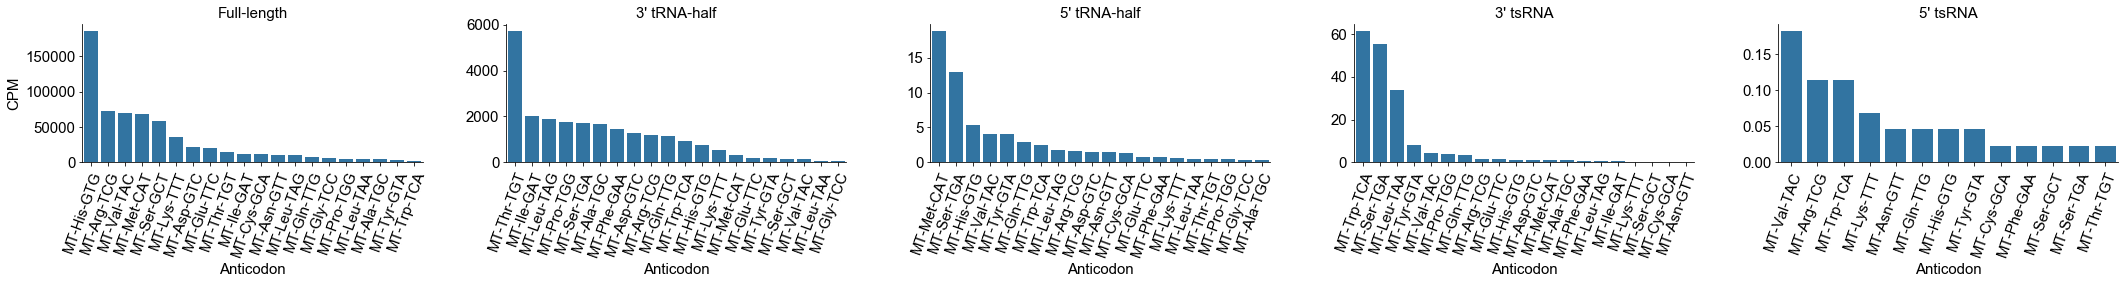

In [244]:
p = sns.FacetGrid(data = df\
        .query('prep == "DNase I"')\
        .pipe(lambda d: d[d.anticodon.str.contains('MT')])\
        .groupby(['anticodon','frag_type'], as_index=False)\
        .agg({'frag_count':'sum'}) \
        .assign(cpm = lambda d: d.frag_count.transform(lambda x: 1e6 * x/cpm_base.prep_cpm['DNase I'])) \
        .query('cpm >0') \
        .groupby('frag_type', as_index=False)\
        .apply(lambda d: d.nlargest(20, 'cpm')),
    col = 'frag_type',
    sharex=False,
    sharey=False,
    col_order = tsRNA,
    aspect=2,
    size=3)
p.map(sns.barplot,
    'anticodon',
    'cpm')
p.set_titles('{col_name}')
for ax in p.fig.axes:
    ax.set_xticklabels(ax.get_xticklabels(), 
                       rotation=70,
                       rotation_mode='anchor',
                      ha='right')
p.set_axis_labels('Anticodon','CPM')
p.savefig(figure_path + '/tsRNA_mt_bar.pdf', bbox_inches='tight')

In [21]:
ce = color_encoder()
ce.encoder = {l:c for l,c in zip(['Mt-tRNA','tRNA'][::-1],['#0e238c','#edc03b'])}
comp_df = pd.read_feather('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/tsRNA.feather')  \
    .assign(prep = lambda d: d.samplename.map(label_sample))\
    .assign(is_mt = lambda d: np.where(d.tRNA.str.startswith('MT'),'Mt-tRNA','tRNA')) \
    .groupby(['prep','is_mt','anticodon','tRNA','aa'], as_index=False)\
    .agg({'frag_count':'sum'})\
    .assign(cpm = lambda d: d.groupby('prep').frag_count.transform(lambda x: 1e6*x/x.sum()))\
    .assign(log_cpm = lambda d: d.cpm.transform(np.log10))\
    .assign(color = lambda d: d.is_mt.map(ce.encoder)) \
    .pipe(pd.pivot_table,
         index = ['is_mt','anticodon','tRNA','aa','color'],
         columns = 'prep',
         values = 'log_cpm',
         fill_value = 0) \
    .reset_index() \
    .merge(read_PNAS())
comp_df.head()

,is_mt,anticodon,tRNA,aa,color,Crude,Crude (MNase),DNase I,DNase I + Exo I,DNase I - 3'P,EV,EV (MNase),Fragmented,HEK293,High salt (450mM),NaOH,RNP,RNP (MNase),Untreated,PNAS_HEK293T
0,Mt-tRNA,CAT,MT-TM,Met,#edc03b,2.147073,2.238149,4.577559,4.768219,4.381204,1.651013,1.628831,4.534036,4.029759,4.888677,4.717235,2.254378,2.246157,4.344883,14.344687
1,tRNA,CAT,TRIMET-CAT-1-1,iMet,#0e238c,4.705400,4.791970,4.348400,4.145390,4.326551,4.648863,4.693325,4.295792,4.315961,3.580156,3.982150,4.685419,4.766995,4.294847,14.344687
2,tRNA,CAT,TRIMET-CAT-2-1,iMet,#0e238c,4.191434,4.194141,3.907481,3.738048,3.942396,4.146435,4.228366,3.885165,3.500132,3.171128,3.659323,4.180191,4.186698,3.711531,14.344687
3,tRNA,CAT,TRM-CAT-1-1,Met,#0e238c,3.874153,3.780060,3.272256,2.970279,3.401633,3.988398,3.881162,3.186285,2.829327,1.730451,2.781056,3.923280,3.785848,3.006033,14.344687
4,tRNA,CAT,TRM-CAT-2-1,Met,#0e238c,2.381812,2.348266,1.866581,1.531758,2.048533,2.580994,2.371178,1.837734,2.727646,0.092961,0.000000,2.469222,2.402850,1.296813,14.344687


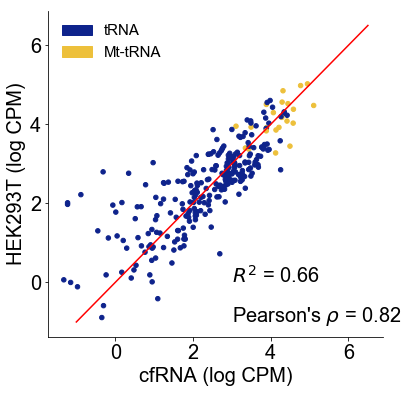

In [27]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
x = 'DNase I'
y = 'HEK293'
comp_df.plot.scatter(x = x, 
            y = y,
            color = comp_df.color.tolist(),
            ax = ax)
ax.plot([-1,6.5],[-1,6.5], color = 'red')
ce.show_legend(ax = ax, fontsize=15,
              frameon=False)
r2 = r2_score(comp_df[x], comp_df[y])
r, pval = pearsonr(comp_df[x], comp_df[y])
ax.text(3,-1, "Pearson's " r'$\rho$ = %.2f' %(r), fontsize=20, ha='left')
ax.text(3,0, r'$R^2$ = %.2f' %(r2), fontsize=20, ha='left')
ax.set_xlabel('cfRNA (log CPM)')#,weight='bold')
ax.set_ylabel('HEK293T (log CPM)')#,weight='bold')
sns.despine()
fig.savefig(figure_path + '/tsRNA_cell.pdf', bbox_inches='tight')

In [59]:
comp_df = pd.read_feather('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/tsRNA.feather')  \
    .assign(prep = lambda d: d.samplename.map(label_sample))\
    .assign(is_mt = lambda d: np.where(d.tRNA.str.startswith('MT'),'Mt-tRNA','tRNA')) \
    .groupby(['prep','is_mt','anticodon','aa'], as_index=False)\
    .agg({'frag_count':'sum'}) \
    .pipe(lambda d: d[~d.is_mt.str.contains('Mt')]) \
    .pipe(pd.pivot_table, index=['anticodon','aa'], values='frag_count', columns='prep')\
    .pipe(lambda d: normalize_count(d))\
    .pipe(np.log2)\
    .reset_index()\
    .merge(read_PNAS())
comp_df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:124: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  nthreads=int_use_threads)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,anticodon,aa,Crude,Crude (MNase),DNase I,DNase I + Exo I,DNase I - 3'P,EV,EV (MNase),Fragmented,HEK293,High salt (450mM),NaOH,RNP,RNP (MNase),Untreated,PNAS_HEK293T
0,AAC,Val,16.028229,16.273556,17.001720,16.823127,17.033805,15.731410,15.789989,17.268147,15.914282,17.902846,17.179318,15.797614,16.046166,18.034796,14.130928
1,AAG,Leu,15.625913,15.516935,16.009921,15.558993,16.254255,15.516935,15.541787,16.367926,13.915274,14.692699,15.298466,15.611546,15.603629,15.843279,12.620475
2,AAT,Ile,17.004199,16.785099,15.902524,16.145967,15.966525,16.562111,17.056883,15.662786,16.768737,17.076904,16.773804,16.765845,16.631181,16.644056,14.759354
3,ACG,Arg,13.906027,14.007210,14.117847,14.168361,14.431334,14.399936,14.051948,14.051457,14.462168,13.680215,13.748269,14.021974,13.917380,13.463975,14.169908
4,AGA,Ser,14.847212,14.878352,13.801390,13.944369,13.858605,14.607497,14.661673,13.587109,13.679386,13.618742,14.333231,14.683375,14.949463,13.705671,14.221122


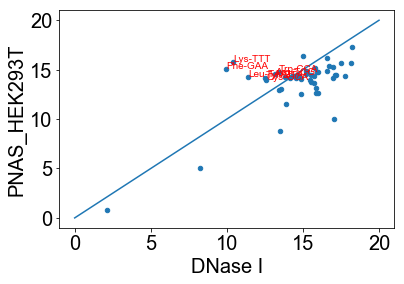

In [65]:
ax = plt.subplot()
comp_df.plot.scatter('DNase I','PNAS_HEK293T', ax=ax, alpha=1)
for i, row in comp_df.iterrows():
    x = row['DNase I']
    y = row['PNAS_HEK293T']
    if y > x*1.1:
        ax.text(x,y,
           row['aa'] + '-' + row['anticodon'],color='red')
ax.plot([0,20],[0,20])

In [43]:
comp_df.PNAS_HEK293T.sum()

673.0527729793687